In [1]:
# python 3.6.8+
# https://www.leonardofilipe.com
# contact at leonardofilipe.com

# For yahoo finance
import io
import re
import requests

# The usual suspects
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

# Tree models and data pre-processing
from numpy               import vstack, hstack
from sklearn             import tree

# Fancy graphics
plt.style.use('seaborn')

# Getting Yahoo finance data
def getdata(tickers,start,end,frequency):
    OHLC = {}
    cookie = ''
    crumb = ''
    res = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0,
                                   error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

def ATR(df, n):
    df = df.reset_index()
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    return pd.Series(TR_l).ewm(span=n, min_periods=n).mean()

# Assets under consideration
tickers = ['PEP','KO']

data = None
while data is None:
    try:
        data = getdata(tickers,'946684800','1551225600','1d')
    except:
         pass

KO = data['KO']
KO = KO.drop('Volume',axis=1)
PEP = data['PEP']
PEP = PEP.drop('Volume',axis=1)
PEP.tail()

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-02-20,115.750000,116.639999,115.410004,115.830002,115.830002
2019-02-21,115.500000,116.930000,115.470001,116.099998,116.099998
2019-02-22,116.110001,116.769997,115.589996,116.760002,116.760002
2019-02-25,117.169998,117.300003,115.709999,116.059998,116.059998
2019-02-26,116.370003,116.500000,115.430000,115.970001,115.970001


In [2]:
variables = pd.DataFrame({'TPEP':(PEP['Close']/PEP['Close'].shift(7)-1).shift(1),
                      'TKO':(KO['Close']/KO['Close'].shift(6)-1).shift(1)})

variables['Target'] = variables.min(axis=1)

variables['APEP'] = PEP['Open']
variables['AKO'] = KO['Open']

variables['CPEP'] = PEP['Close']
variables['CKO'] = KO['Close']

variables['IsPEP'] = variables['Target'].isin(variables['TPEP'])

variables['Sell'] = np.where(variables['IsPEP'],
                             variables['CPEP'],
                             variables['CKO'])

variables['Buy'] = np.where(variables['IsPEP'],
                            variables['APEP'],
                            variables['AKO'])

variables = variables.reset_index().drop('Date',axis=1)

variables['ATR'] = ATR(PEP,40)

variables = variables.dropna()
variables = variables.reset_index().drop('index',axis=1)

features  = ['IsPEP','AKO','ATR','APEP']

In [3]:
training = 38
testing = 3

cumret, trade, worstt = [], [], []

for ii in range(0, len(variables)-(training+testing), testing):
    X, y = [], []

    iam  = ii+training
    lazy = ii+training+testing

    # Training a Decision Tree Regressor with the last 38 days
    for i in range(ii, iam):
        X.append([variables.iloc[i][var] for var in features])
        y.append(variables.iloc[i].Sell)

    model = tree.DecisionTreeRegressor(max_depth=19, min_samples_leaf=3, min_samples_split=16)
    model.fit(vstack(X), hstack(y))

    XX = []

    # Testing the model out-of-sample, its used for the next 3 days
    for i in range(iam, lazy):
        XX.append([variables.iloc[i][var] for var in features])

    results = pd.Series(model.predict(vstack(XX)),variables[iam:lazy].index)
    popen = variables['Buy'][iam:lazy]
    pclose = variables['Sell'][iam:lazy]

    # We trade if the predicted close price is superior to the open price
    trades = pd.Series(np.where(results > popen, pclose/popen-1, np.nan),variables[iam:lazy].index)

    # Exporting some results
    try:
        worstt.append(np.min(trades))
        trade.append(len(trades.dropna()))
        cumret.append(float(trades.dropna().cumsum()[-1:]))
    except:
        0

In [4]:
returns = pd.Series(cumret)
returns.describe() #out-of-sample 3days returns

count    1064.000000
mean        0.002188
std         0.017005
min        -0.114342
25%        -0.005862
50%         0.002418
75%         0.010243
max         0.112341
dtype: float64

In [5]:
pd.Series(trade).mean()/testing #execution rate

0.46886214903947643

In [6]:
pd.Series(worstt).dropna().describe() #worst 1day returns

count    1064.000000
mean       -0.003536
std         0.011458
min        -0.089762
25%        -0.009015
50%        -0.003274
75%         0.002220
max         0.048673
dtype: float64

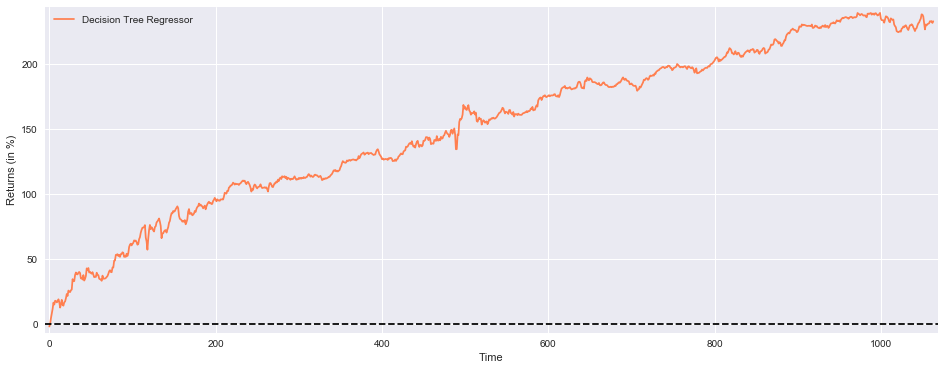

In [7]:
plt.figure(figsize=(16,6))
plt.plot((returns.cumsum())*100, label='Decision Tree Regressor', color='coral')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [8]:
model.feature_importances_

array([9.97414240e-01, 3.78414724e-04, 0.00000000e+00, 2.20734511e-03])